# Data Analysis

In [68]:
!gdown 14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
!gdown 1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_

Downloading...
From: https://drive.google.com/uc?id=14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
To: /content/wnut 16.txt.conll
100% 403k/403k [00:00<00:00, 200MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_
To: /content/wnut 16test.txt.conll
100% 635k/635k [00:00<00:00, 135MB/s]


In [69]:
#%pip install datasets transformers
#%pip install tensorflow-addons

In [70]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import string
import re
import random
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import word2vec, FastText
import gensim.downloader
from sklearn.decomposition import PCA

In [ ]:
import pandas as pd

# Define the file path
file_path = "wnut 16.txt.conll"


# Read the .conll file into a DataFrame
data = []
sentences = []
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            tokens = line.split('\t')
            data.append(tokens)
        else:
            if data:
                sentences.append(data)
                data = []

# Create a DataFrame with Sentence, Token, and POS columns
df_train = pd.DataFrame(columns=['Sentence', 'Token', 'POS'])
for i, sentence in enumerate(sentences):
    for token in sentence:
        df_train = df_train.append({'Sentence': i+1, 'Token': token[0], 'POS': token[1]}, ignore_index=True)

# Print the resulting DataFrame
#print(df)

In [ ]:

import pandas as pd

# Define the file path
file_path = "wnut 16test.txt.conll"


# Read the .conll file into a DataFrame
data = []
sentences = []
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            tokens = line.split('\t')
            data.append(tokens)
        else:
            if data:
                sentences.append(data)
                data = []

# Create a DataFrame with Sentence, Token, and POS columns
df_test = pd.DataFrame(columns=['Sentence', 'Token', 'POS'])
for i, sentence in enumerate(sentences):
    for token in sentence:
        df_test=df_test.append({'Sentence': i+1, 'Token': token[0], 'POS': token[1]}, ignore_index=True)

# Print the resulting DataFrame
#print(df)


In [73]:
# import pandas as pd
# column_names = ['Token', 'POS']
# df_train = pd.read_csv("wnut 16.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_test = pd.read_csv("wnut 16test.txt.conll", sep='\t', header=None,names=column_names ,comment='#')
# df_train.head()

In [74]:
df_train['Sentence']='sentence '+df_train['Sentence'].astype(str)
df_test['Sentence']='sentence '+(df_test['Sentence']+2393).astype(str)

In [75]:
df=pd.concat([df_train,df_test])

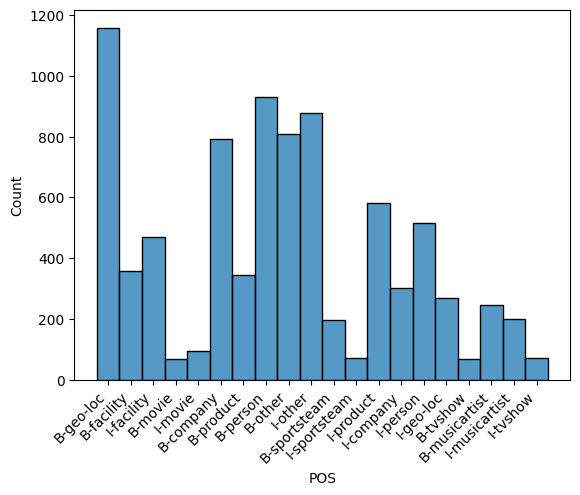

In [76]:
sns.histplot(df[df['POS']!='O']['POS'])
plt.xticks(rotation=45, ha='right')
plt.show()

Clearly there is imbalance in the dataset. Person, Other and loc has the highest count compare to other tags. We will take care of that in loss

In [77]:
df.info() #There seems to be no null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108358 entries, 0 to 61895
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  108358 non-null  object
 1   Token     108358 non-null  object
 2   POS       108358 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


In [78]:
print('Number of sentences are '+str(df['Sentence'].nunique()))
print('Number of Vocabs are '+str(df['Token'].nunique()))

Number of sentences are 6242
Number of Vocabs are 25379


## Model Building Attention + CRF

## Data Preprocessing

In [ ]:
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import gensim.downloader as api
from tensorflow.keras.layers import Embedding

tf.random.set_seed(123)

In [ ]:
#Creating a word and it's tag set
sentence_all=[]
for i in df.Sentence.unique():
  sentence_all.append(list(zip(df[df['Sentence']==i]['Token'], df[df['Sentence']==i]['POS'])))

In [ ]:
sentence_all[0] #1st Sentence

[('@sammielynnsmom', 'O'),
 ('@tg10781', 'O'),
 ('they', 'O'),
 ('will', 'O'),
 ('be', 'O'),
 ('all', 'O'),
 ('done', 'O'),
 ('by', 'O'),
 ('sunday', 'O'),
 ('trust', 'O'),
 ('me', 'O'),
 ('*wink*', 'O')]

In [ ]:
# sentences = []
# for sample in sentence_all:
#   sentence = [i[0] for i in sample]
#   sentences.append(sentence)

# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=df['Token'].nunique(), lower=True)
# tokenizer.fit_on_texts(sentences)

In [ ]:
#tokenizer.shape

In [ ]:
#tokenizer.word_index.items()

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [ ]:
#! pip install keras_preprocessing

In [ ]:
df['Token']=df['Token'].str.lower()

In [ ]:
words = list(set(df['Token'].values))
tags = list(set(df["POS"].values))

In [ ]:
#Creating word to index and tag to index
import sklearn

# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}


In [ ]:
# Embedding the word matrix, we will add this
hits = 0
misses = 0
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300

# Prepare embedding matrix
embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in zip(word2idx.keys(),word2idx.values()):
    embedding_vector = None
    try:
      embedding_vector = word2vec[word]
    except Exception :
      pass

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9678 words (12254 misses)


In [ ]:
#Tagging word to index and tag to index

#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentence_all]

# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=75, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical

# One-Hot encode
y = [to_categorical(i, num_classes=len(tags)+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape


print('Raw Sample:\n ', ' '.join([w[0] for w in sentence_all[1]]))
print('\n ' )
print('Raw Label:\n ', ' '.join([w[1] for w in sentence_all[1]]))
print('\n ' )
print('After processing, sample:\n', X[0])
print('\n ' )
print('After processing, labels:\n', y[0])

Raw Sample:
  made it back home to ga . it sucks not to be at disney world , but its good to be home . time to start planning the next disney world trip .

 
Raw Label:
  O O O O O B-geo-loc O O O O O O O B-facility I-facility O O O O O O O O O O O O O O B-facility I-facility O O

 
After processing, sample:
 [20845  3402  4402 11722  2955  5794 13934  6589 14094  9704  9160  3845
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

 
After processing, labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
len(word2idx)

21932

In [ ]:
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((5617, 75), (625, 75), (5617, 75, 22), (625, 75, 22))

In [ ]:
y_tr = np.array(y_tr)
y_te = np.array(y_te)

In [ ]:
#! pip install tensorflow_addons

In [ ]:
# !pip install tensorflow-addons
# !pip install tensorflow==2.0.0-beta1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0-beta1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2)
ERROR: No matching distribution found for tensorflow==2.0.0-beta1


## Model Building

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike
from tensorflow_addons.layers import CRF
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW



def build_model(max_len = 75, input_dim = len(word2idx),embedding_dim = 300):
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(
      input_dim,
      embedding_dim,
      weights=[embedding_matrix],
    input_length=max_len,
       mask_zero=True,
    trainable=True,
      name = 'embedding_layer'
  )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)
  output_sequences = Bidirectional(LSTM(units=100, return_sequences=True))(output_sequences)
  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  mask = Input(shape=(max_len,), dtype=tf.bool)
  crf = CRF(22, name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=10)

callbacks = [save_model, es]

model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 75)]              0         
                                                                 
 embedding_layer (Embedding)  (None, 75, 300)          6579600   
                                                                 
 bidirectional_54 (Bidirecti  (None, 75, 100)          140400    
 onal)                                                           
                                                                 
 bidirectional_55 (Bidirecti  (None, 75, 200)          160800    
 onal)                                                           
                                                                 
 bidirectional_56 (Bidirecti  (None, 75, 100)          100400    
 onal)                                                           
                                                          

In [ ]:
history = model.fit(
  X_tr,
  y_tr,
  batch_size=64,
  epochs=20,
  validation_data=(X_te, y_te),
  callbacks=callbacks,
  shuffle=True
)

Epoch 1/20


88/88 [==============================] - ETA: 0s - loss: 0.6434
Epoch 1: val_loss improved from inf to 0.42915, saving model to ner_crf.h5
88/88 [==============================] - 115s 1s/step - loss: 0.6434 - val_loss: 0.4291
Epoch 2/20
88/88 [==============================] - ETA: 0s - loss: 0.3573
Epoch 2: val_loss improved from 0.42915 to 0.29394, saving model to ner_crf.h5
88/88 [==============================] - 85s 971ms/step - loss: 0.3573 - val_loss: 0.2939
Epoch 3/20
88/88 [==============================] - ETA: 0s - loss: 0.2502
Epoch 3: val_loss improved from 0.29394 to 0.21154, saving model to ner_crf.h5
88/88 [==============================] - 80s 914ms/step - loss: 0.2502 - val_loss: 0.2115
Epoch 4/20
88/88 [==============================] - ETA: 0s - loss: 0.1813
Epoch 4: val_loss improved from 0.21154 to 0.15745, saving model to ner_crf.h5
88/88 [==============================] - 81s 922ms/step - loss: 0.1813 - val_loss: 0.1574
Epoch 5/20
88/88 [=======================

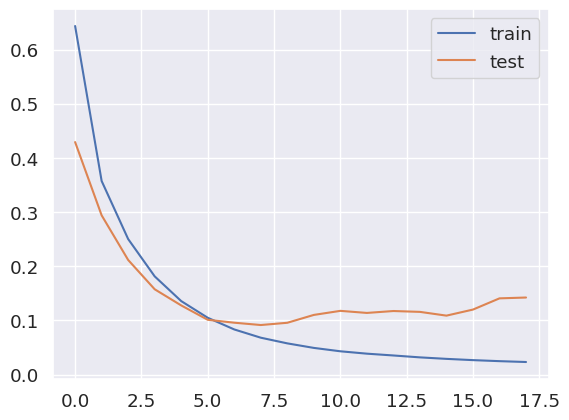

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Since it's still reducing there is a chance it will reduce more with more hyperparam tuning but loss of 0.02 for train and 0.14 with test looks great

20/20 [==============================] - 10s 110ms/step


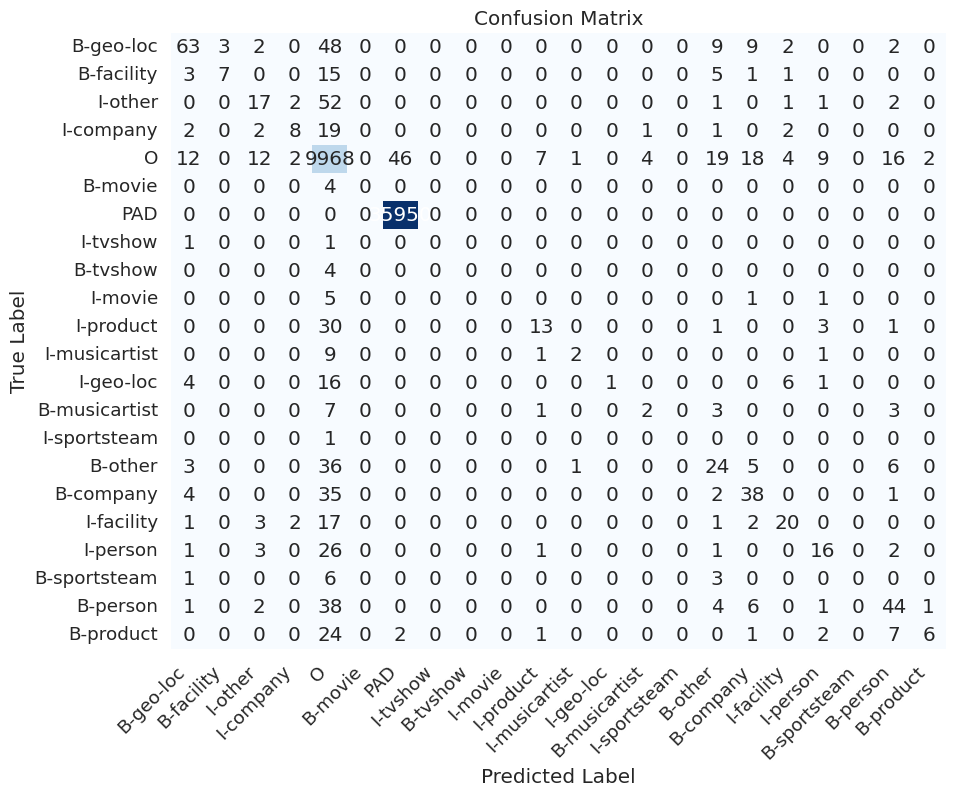

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
predictions = model.predict(X_te)

# Convert predictions to POS tags
predicted_tags = np.argmax(predictions, axis=-1)
predicted_tags = [[idx2tag[tag] for tag in sample] for sample in predicted_tags]

# Flatten the predicted and true POS tag sequences
flatten_predicted = [tag for sample in predicted_tags for tag in sample]
flatten_true = [idx2tag[np.argmax(tag)] for sample in y_te for tag in sample]

# Get unique tags from the true and predicted sequences
unique_tags = list(set(flatten_true + flatten_predicted))

# Compute the confusion matrix
cm = confusion_matrix(flatten_true, flatten_predicted, labels=unique_tags)

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=unique_tags, columns=unique_tags)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Plot the confusion matrix as a heatmap
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:\n ", classification_report(flatten_predicted, flatten_true, labels=unique_tags))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                 precision    recall  f1-score   support

    B-geo-loc       0.46      0.66      0.54        96
   B-facility       0.22      0.70      0.33        10
      I-other       0.22      0.41      0.29        41
    I-company       0.23      0.57      0.33        14
            O       0.98      0.96      0.97     10361
      B-movie       0.00      0.00      0.00         0
          PAD       1.00      1.00      1.00     35998
     I-tvshow       0.00      0.00      0.00         0
     B-tvshow       0.00      0.00      0.00         0
      I-movie       0.00      0.00      0.00         0
    I-product       0.27      0.54      0.36        24
I-musicartist       0.15      0.50      0.24         4
    I-geo-loc       0.04      1.00      0.07         1
B-musicartist       0.12      0.29      0.17         7
 I-sportsteam       0.00      0.00      0.00         0
      B-other       0.32      0.32      0.32        74
    B-company       0.47      0.47     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I can see that due to imbalance there are many category with less f1 score. Altough overall accuracy looks good the rest are not much useful. We have used SigmoidFocalCrossEntropy but still getting less score. We could use either re-sampling method or more training

In [ ]:
import numpy as np

def get_pos_tags(sentence):
    # Tokenize the sentence
    tokens = sentence.lower().split()

    # Convert tokens to word indices
    word_indices = [word2idx.get(token, word2idx["UNK"]) for token in tokens]

    # Pad the sequence
    padded_sequence = pad_sequences([word_indices], maxlen=MAX_LEN, padding="post", value=word2idx["PAD"])

    # Make predictions
    predictions = model.predict(padded_sequence)[0]

    # Convert predictions to POS tags
    pos_tags = [idx2tag[np.argmax(pred)] for pred in predictions]

    return list(zip(tokens, pos_tags))

# Example usage
input_sentence = "I wanted to go to Disney Land"
output = get_pos_tags(input_sentence)

# Print the output
for token, pos_tag in output:
    print(f"Token: {token:<10} Predicted POS: {pos_tag}")


1/1 [==============================] - 0s 100ms/step
Token: i          Predicted POS: O
Token: wanted     Predicted POS: O
Token: to         Predicted POS: O
Token: go         Predicted POS: O
Token: to         Predicted POS: O
Token: disney     Predicted POS: B-person
Token: land       Predicted POS: I-other


This is the prediction of the sentence

# OverSampling and BERT

## Preprocessing

In [1]:
#! pip install transformers


In [79]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [80]:
# sentence = df.groupby("Sentence")["Token"].apply(list).values
# #pos = dataframe.groupby(by = 'Sentence #')['POS'].apply(list).values
# tag = df.groupby(by = 'Sentence')['POS'].apply(list).values

In [94]:
# Over Sampling
lst = [df]
max_size = 1356
for class_index, group in df.groupby('POS'):
        if len(group)< max_size:
            lst.append(group.sample(max_size-len(group), replace=True))
train_sample = pd.concat(lst)

In [95]:
train_sample=train_sample.sort_values(by='Sentence')

In [96]:
# Token and POS Encoding
def process_data(df):
    enc_pos = preprocessing.LabelEncoder()
    #enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])

    sentences = df.groupby("Sentence")["Token"].apply(list).values
    pos = df.groupby("Sentence")["POS"].apply(list).values
    return sentences, pos, enc_pos

sentence,pos,enc_pos = process_data(train_sample.copy())

<ipython-input-96-931d81ea1267>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])


In [97]:
#pos

In [98]:
# Using BERT Auto-Tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 256
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [99]:
# Train test split
X_train,X_test,y_train,y_test = train_test_split(sentence,pos,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((5617,), (625,), (5617,), (625,))

In [100]:
# Calling tokenization function
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 625/625 [00:00<00:00, 3073.78it/s]


In [101]:
#val_input_ids

In [102]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{256}

In [103]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (MAX_LEN-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{256}

In [104]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (MAX_LEN-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{256}

In [105]:
#train_tag[0].shape

##Modeling

In [116]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(22,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [117]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [118]:
with strategy.scope():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    model = create_model(bert_model,MAX_LEN)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [119]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_9[0][0]',                
                                thPoolingAndCrossAt               'input_10[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [127]:
early_stopping = EarlyStopping(mode='min',patience=3)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 20,batch_size = 32,callbacks = early_stopping,verbose = True)

Epoch 1/20
176/176 [==============================] - 326s 2s/step - loss: 0.0515 - accuracy: 0.9835 - val_loss: 0.0575 - val_accuracy: 0.9836
Epoch 2/20
176/176 [==============================] - 325s 2s/step - loss: 0.0490 - accuracy: 0.9841 - val_loss: 0.0566 - val_accuracy: 0.9834
Epoch 3/20
176/176 [==============================] - 326s 2s/step - loss: 0.0470 - accuracy: 0.9845 - val_loss: 0.0557 - val_accuracy: 0.9837
Epoch 4/20
176/176 [==============================] - 325s 2s/step - loss: 0.0451 - accuracy: 0.9848 - val_loss: 0.0547 - val_accuracy: 0.9837
Epoch 5/20
176/176 [==============================] - 317s 2s/step - loss: 0.0435 - accuracy: 0.9852 - val_loss: 0.0562 - val_accuracy: 0.9843
Epoch 6/20
176/176 [==============================] - 316s 2s/step - loss: 0.0423 - accuracy: 0.9854 - val_loss: 0.0569 - val_accuracy: 0.9843
Epoch 7/20
176/176 [==============================] - 325s 2s/step - loss: 0.0406 - accuracy: 0.9859 - val_loss: 0.0566 - val_accuracy: 0.9844

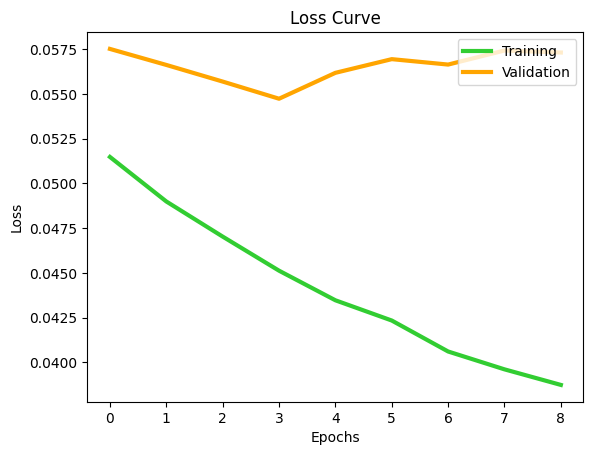

In [130]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(history_bert.history['loss'],linewidth=3,color='limegreen')
plt.plot(history_bert.history['val_loss'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="upper right")

20/20 [==============================] - 12s 611ms/step


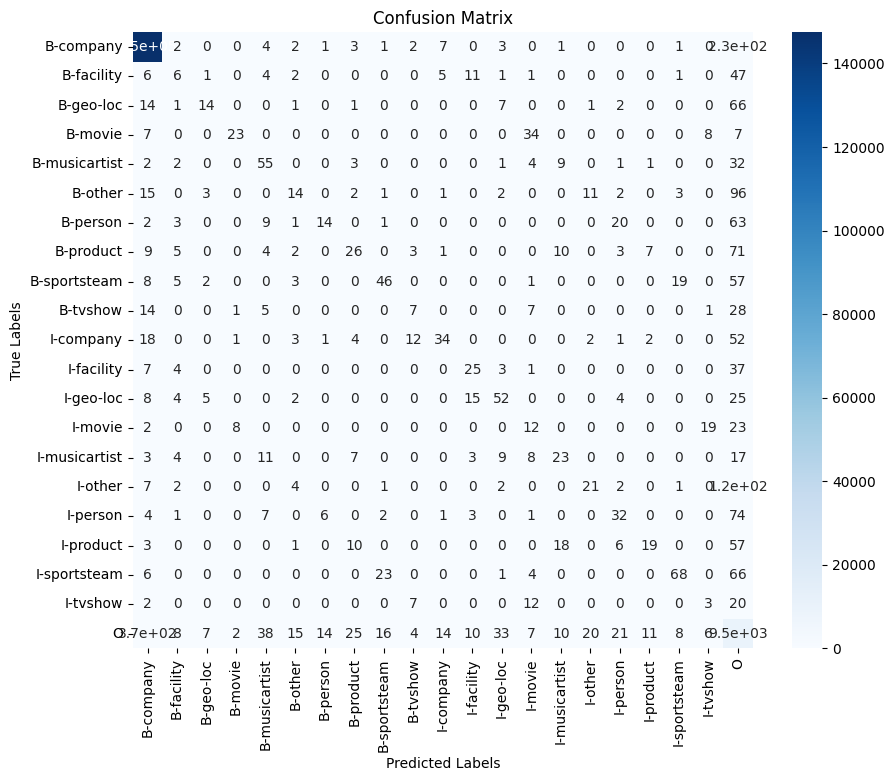

In [131]:
predictions = model.predict([val_input_ids, val_attention_mask])
predicted_labels = np.argmax(predictions, axis=2)
true_labels_flat = np.concatenate(test_tag)
predicted_labels_flat = np.concatenate(predicted_labels)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_flat, predicted_labels_flat)
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
import seaborn as sns
label_names = enc_pos.classes_  # Assuming `enc_pos` is the label encoder used in your code

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [132]:
y_pred = np.argmax(model.predict([val_input_ids, val_attention_mask]), axis=2)
y_pred_labels = enc_pos.inverse_transform(y_pred.reshape(-1))
y_true_labels = np.array(test_tag).flatten()
encoded_pred_labels = enc_pos.transform(y_pred_labels)
from sklearn.metrics import classification_report
label_names = enc_pos.inverse_transform(np.arange(len(enc_pos.classes_)))

report = classification_report(y_true_labels, encoded_pred_labels, target_names=label_names)
print(report)


20/20 [==============================] - 12s 592ms/step
               precision    recall  f1-score   support

    B-company       1.00      1.00      1.00    147740
   B-facility       0.13      0.07      0.09        85
    B-geo-loc       0.44      0.13      0.20       107
      B-movie       0.66      0.29      0.40        79
B-musicartist       0.40      0.50      0.45       110
      B-other       0.28      0.09      0.14       150
     B-person       0.39      0.12      0.19       113
    B-product       0.32      0.18      0.23       141
 B-sportsteam       0.51      0.33      0.40       141
     B-tvshow       0.20      0.11      0.14        63
    I-company       0.54      0.26      0.35       130
   I-facility       0.37      0.32      0.35        77
    I-geo-loc       0.46      0.45      0.45       115
      I-movie       0.13      0.19      0.15        64
I-musicartist       0.32      0.27      0.29        85
      I-other       0.38      0.13      0.20       158
     I-p

Overall accuracy has gone down 1% but the category wise accuracy has increased in many places. Oversampling and pretrained BERT could be the reason of increase